# Assignment-5-d - Forecasting Energy Demand


In [1]:
!pip install -Uqq nixtla neuralforecast utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [21]:
import time
import requests
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate
from nixtla.utils import in_colab
from google.colab import userdata
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')

In [22]:
IN_COLAB = in_colab()

In [6]:
nixtla_client = NixtlaClient(
    api_key = NIXTLA_API_KEY
)

## Forecasting with TimeGPT

In [23]:
start_date_string = '2002-01-01 00:00:00'

In [24]:
def read_tsf_from_url(url):
    data = []
    start_date = pd.to_datetime(start_date_string)

    # Fetch the content from the URL
    response = requests.get(url)
    response.raise_for_status()

    # Process each line of the file
    for line in response.text.splitlines():
        if line.startswith('T'):
            parts = line.strip().split(':')
            unique_id = parts[0] + '-' + parts[1]
            values = list(map(float, parts[3].split(',')[:-1]))

            # Generate datetime index at half-hour intervals
            periods = len(values)
            date_range = pd.date_range(start=start_date, periods=periods, freq='30min')

            # Append to data list
            for dt, value in zip(date_range, values):
                data.append([unique_id, dt, value])

    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

In [25]:
url = 'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/australian_electricity_demand_dataset.tsf'
df = read_tsf_from_url(url)

In [26]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
230735,T2-VIC,2002-01-01 00:00:00,3535.867064
230736,T2-VIC,2002-01-01 00:30:00,3383.499028
461470,T3-QUN,2002-01-01 00:00:00,3382.041342
461471,T3-QUN,2002-01-01 00:30:00,3288.315794
693741,T4-SA,2002-01-01 00:00:00,1191.078014
693742,T4-SA,2002-01-01 00:30:00,1219.589472
924524,T5-TAS,2002-01-01 00:00:00,315.915504
924525,T5-TAS,2002-01-01 00:30:00,306.245864


### Plot Data

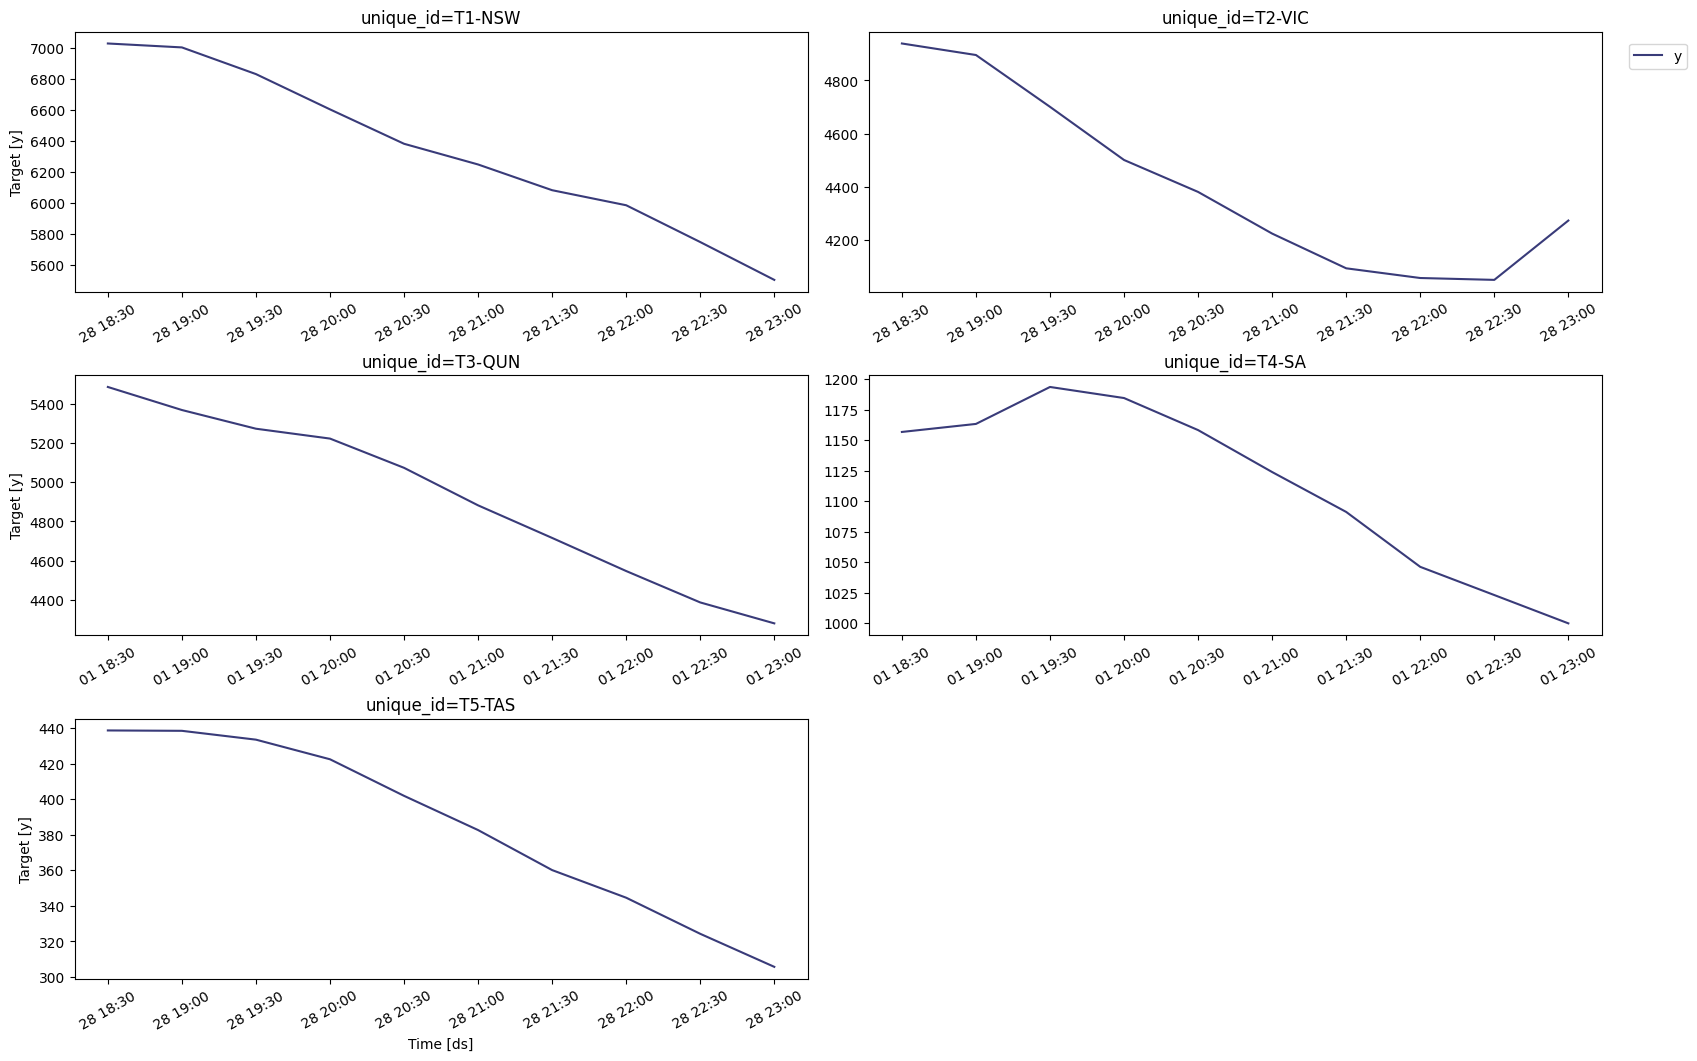

In [28]:
nixtla_client.plot(
    df,
    max_insample_length=10,
)

In [12]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 2 days (96 * 0.5h *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)

<ipython-input-12-c1386d4cb0ca>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)


In [13]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 3.23819899559021


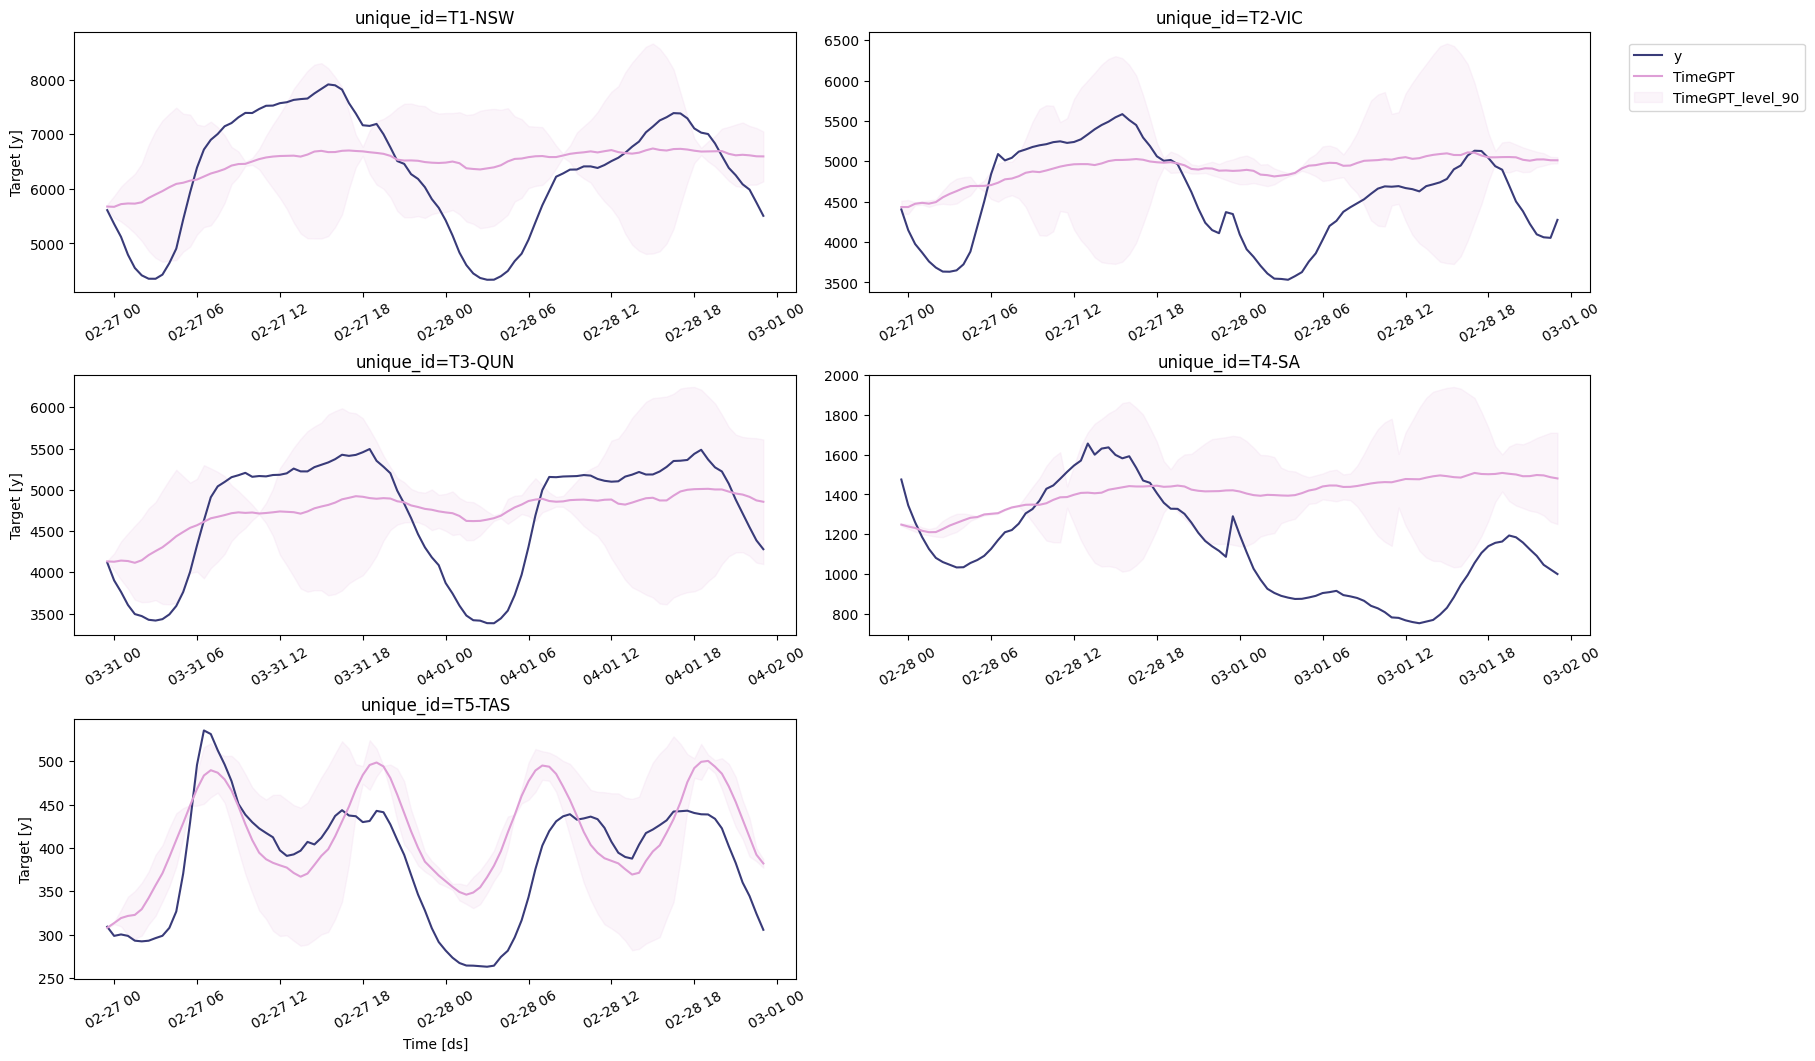

In [14]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

### Evaluation

In [15]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [16]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

,TimeGPT
metric,
mae,436.787046
smape,0.075237


### Define Training Set

In [18]:
train_df = df.groupby('unique_id').apply(lambda group: group.iloc[-9696:-96]).reset_index(drop=True)

<ipython-input-18-dd4b155c9a49>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda group: group.iloc[-9696:-96]).reset_index(drop=True)


### Evaluation

In [20]:
preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

metric
mae      181.557129
smape      0.044379
Name: NHITS, dtype: float64
